In [32]:
### ignore warning 
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 

import numpy as np
import pandas as pd
import re
import glob
import spacy 
import nltk
import os
import nltk
from nltk.tokenize import TreebankWordTokenizer ,word_tokenize
from nltk.stem import PorterStemmer , WordNetLemmatizer
from nltk import ngrams
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk import everygrams
from nltk.tokenize.treebank import TreebankWordDetokenizer
#from nltk.tokenize.treebank import TreebankWordDetokenizer
# TreebankWordDetokenizer().detokenize(['the', 'quick', 'brown'])
# nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
import string
from nltk import everygrams

# display  max row 
#pd.set_option("display.max_rows", None)
import ast
import tensorflow as tf
## tqdm 
from tqdm._tqdm_notebook import tqdm_notebook,tqdm
tqdm_notebook.pandas()

[nltk_data] Downloading package punkt to /home/nick/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/nick/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [433]:
! pip install tensorflow

In [434]:
# -คู่ค่า 
# -คู่เเข่ง      
# - country 
# - related_product  
# - location 
# ประเทสอะไร product อะไร 
#  -คู่ค่า / 
# -คู่เเข่ง 

## Related Product 


In [72]:
path = '/home/nick/DITP/trade-midas/ditp3_run_test/share_between_models'
path2 = '/home/nick/DITP/trade-midas/ditp3_run_test/GNA/corpus'
# relate product  
relate_product = pd.read_csv(f'{path2}/related_product_corpus.csv')
relate_key = relate_product['keyword'].to_list()

# competitor 
comp  =  pd.read_csv(f'{path}/competitors.csv', index_col= False)

# partner
partner =  pd.read_csv(f'{path}/partners.csv' , index_col = False)

### location 

location   =  pd.read_csv(f'{path2}/country_corpus.csv', index_col = False)


### country  iso  3 

country_iso3 = pd.read_csv(f'{path}/country_iso3.csv', index_col = False)


## country wikipedia

country_wiki =  pd.read_csv(f'{path}/wikipedia_country_mapping.csv', index_col = False)
country_wiki.rename(columns={'official_name':'country','Alpha-3 code':'iso3','key_word':'keyword'},inplace=True)
country_wiki = country_wiki[['keyword','country','iso3']]


## partner 
partner =  pd.read_csv(f'{path}/partners.csv', index_col= False)

# competitor 
competiors  =  pd.read_csv(f'{path}/competitors.csv', index_col=False)

In [73]:
country_wiki

,keyword,country,iso3
0,Republic of Abkhazia,Abkhazia,NaN
1,Aphsny Axwynthkharra,Abkhazia,NaN
2,Respublika Abkhaziya,Abkhazia,NaN
3,Autonomous Republic of Abkhazia,Abkhazia,NaN
4,Islamic Republic of Afghanistan,Afghanistan,AFG
...,...,...,...
1201,Northern Rhodesia,Zambia,ZMB
1202,Republic of Zimbabwe,Zimbabwe,ZWE
1203,Rhodesia,Zimbabwe,ZWE
1204,Republic of Rhodesia,Zimbabwe,ZWE


In [74]:
location.drop(columns='Unnamed: 0',errors='ignore',inplace=True)
location

,keyword,country,iso3
0,Guangdong,China,CHN
1,Fujian,China,CHN
2,Inner Mongolia,China,CHN
3,Shaanxi,China,CHN
4,Yunnan,China,CHN
...,...,...,...
13571,Colombie-Britannique,NaN,Unknown code
13572,Québec,NaN,Unknown code
13573,Nouveau-Brunswick,NaN,Unknown code
13574,Nouvelle-Écosse,NaN,Unknown code


In [75]:
country_wiki

,keyword,country,iso3
0,Republic of Abkhazia,Abkhazia,NaN
1,Aphsny Axwynthkharra,Abkhazia,NaN
2,Respublika Abkhaziya,Abkhazia,NaN
3,Autonomous Republic of Abkhazia,Abkhazia,NaN
4,Islamic Republic of Afghanistan,Afghanistan,AFG
...,...,...,...
1201,Northern Rhodesia,Zambia,ZMB
1202,Republic of Zimbabwe,Zimbabwe,ZWE
1203,Rhodesia,Zimbabwe,ZWE
1204,Republic of Rhodesia,Zimbabwe,ZWE


In [76]:
country_all = pd.concat([location,country_wiki])
country_all.shape

(14782, 3)

In [77]:
#location  

In [78]:
country_all

,keyword,country,iso3
0,Guangdong,China,CHN
1,Fujian,China,CHN
2,Inner Mongolia,China,CHN
3,Shaanxi,China,CHN
4,Yunnan,China,CHN
...,...,...,...
1201,Northern Rhodesia,Zambia,ZMB
1202,Republic of Zimbabwe,Zimbabwe,ZWE
1203,Rhodesia,Zimbabwe,ZWE
1204,Republic of Rhodesia,Zimbabwe,ZWE


In [79]:
country_all[country_all['country'].isnull()]

,keyword,country,iso3
3697,Tokyo,NaN,Unknown code
3698,Kasai,NaN,Unknown code
3702,Chumphon,NaN,Unknown code
3703,Phang Nga,NaN,Unknown code
3704,Ranong,NaN,Unknown code
...,...,...,...
13571,Colombie-Britannique,NaN,Unknown code
13572,Québec,NaN,Unknown code
13573,Nouveau-Brunswick,NaN,Unknown code
13574,Nouvelle-Écosse,NaN,Unknown code


In [80]:
! pip install transformers

# sentiment  

In [84]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [85]:
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer
import torch
# find tuning model  sentiment 
# Create class for data preparation
class SimpleDataset:
    def __init__(self, tokenized_texts):
        self.tokenized_texts = tokenized_texts
    
    def __len__(self):
        return len(self.tokenized_texts["input_ids"])
    
    def __getitem__(self, idx):
        return {k: v[idx] for k, v in self.tokenized_texts.items()}

# Load tokenizer and model, create trainer
model_name = "ahmedrachid/FinancialBERT-Sentiment-Analysis"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
trainer = Trainer(model=model)
 






loading file https://huggingface.co/ahmedrachid/FinancialBERT-Sentiment-Analysis/resolve/main/vocab.txt from cache at /home/nick/.cache/huggingface/transformers/10fd60411922e6e664d5b10bc0709ea0076c7a8f1a328b26c9177883580d6ee7.96da363c8cf320099a2e1f334de3e31c7dd233167e39131096562bd5894c4141
loading file https://huggingface.co/ahmedrachid/FinancialBERT-Sentiment-Analysis/resolve/main/tokenizer.json from cache at /home/nick/.cache/huggingface/transformers/84ebfd74a282bd12de31ff3eee1ce162d4052a876600cb9bdeac538c9bc15826.7a9fb6f256a2976b2ad87cc82e957e0d11d69a74c395435205d27ed8d58c54de
loading file https://huggingface.co/ahmedrachid/FinancialBERT-Sentiment-Analysis/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/ahmedrachid/FinancialBERT-Sentiment-Analysis/resolve/main/special_tokens_map.json from cache at /home/nick/.cache/huggingface/transformers/cf6218e33224354b1a25c4db77b979b33f2434f11976899531dc0a4032f8cb42.dd8bd9bfd3664b530ea4e645105f557769387b3da9

RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [86]:
pred_texts = ['I like that','That is annoying','This is great!','Wouldn´t recommend it.']
tokenized_texts = tokenizer(pred_texts,truncation=True,padding=True)
pred_dataset = SimpleDataset(tokenized_texts)

In [87]:
predictions = trainer.predict(pred_dataset)

NameError: name 'trainer' is not defined

In [90]:


model = BertForSequenceClassification.from_pretrained("ahmedrachid/FinancialBERT-Sentiment-Analysis",num_labels=3)
tokenizer = BertTokenizer.from_pretrained("ahmedrachid/FinancialBERT-Sentiment-Analysis")

nlp = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

sentences = ["Operating profit rose to EUR 13.1 mn from EUR 8.7 mn in the corresponding period in 2007 representing 7.7 % of net sales.",  
             "Bids or offers include at least 1,000 shares and the value of the shares must correspond to at least EUR 4,000.", 
             "Raute reported a loss per share of EUR 0.86 for the first half of 2009 , against EPS of EUR 0.74 in the corresponding period of 2008.", 
             ]
results = nlp(trade_news['clean_content_ner_prep_clean'][0],truncation=True)
print(results)


loading configuration file https://huggingface.co/ahmedrachid/FinancialBERT-Sentiment-Analysis/resolve/main/config.json from cache at /home/nick/.cache/huggingface/transformers/f7a292b3ae49caefb3b6a34cc49d7218640eca0829e10ac7da83e244821a0558.36d800ee65e724d4cdff3e48db31b170d83d4a03b8ae7abf81f2245d18b040be
Model config BertConfig {
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "negative",
    "1": "neutral",
    "2": "positive"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "negative": 0,
    "neutral": 1,
    "positive": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classific

[{'label': 'positive', 'score': 0.9113647937774658}]


In [ ]:
# nlp = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)
# """
# learning_rate = 2e-5
# batch_size = 32
# max_seq_length = 512
# num_train_epochs = 5

# """
# sentences = ["Operating profit rose to EUR 13.1 mn from EUR 8.7 mn in the corresponding period in 2007 representing 7.7 % of net sales.",  
#              "Bids or offers include at least 1,000 shares and the value of the shares must correspond to at least EUR 4,000.", 
#              "Raute reported a loss per share of EUR 0.86 for the first half of 2009 , against EPS of EUR 0.74 in the corresponding period of 2008.", 
#              ]
# results = nlp(sentences)
# print(results[0]['score'])

In [ ]:
# del tokenizer_model 

In [105]:
# tokenizer_model = AutoTokenizer.from_pretrained("ahmedrachid/FinancialBERT-Sentiment-Analysis")
# model = AutoModelForSequenceClassification.from_pretrained("ahmedrachid/FinancialBERT-Sentiment-Analysis")
try: 

    tokenizer_model1 

except :

    tokenizer_model1 = BertTokenizer.from_pretrained("ahmedrachid/FinancialBERT-Sentiment-Analysis")
    

try :
    model1
except :

    model1 = model = BertForSequenceClassification.from_pretrained("ahmedrachid/FinancialBERT-Sentiment-Analysis",num_labels=3)  
    
def sentiment(content_clean,tokenizer_model=tokenizer_model1,model= model1) :
    """
    learning_rate = 2e-5
    batch_size = 32
    max_seq_length = 512
    num_train_epochs = 5

    """  

    
    nlp = pipeline("sentiment-analysis", model=model1, tokenizer=tokenizer_model1)
    results = nlp(content_clean,truncation=True)
    
    return results[0]['label'] ,  results[0]['score']
#     return results['label'] ,  results['score']

In [ ]:
sentiment()

In [6]:
trade_news =  pd.read_csv('./GNA/all_related_trade_news.csv')

In [7]:
trade_news.head()

,published_at,title,description,content,url,url_to_image,tags,id,original_path,publisher,clean_content_prep_clean,clean_content_ner_prep_clean,relevance_trade
0,2021-03-07 00:00:00.000,Crude prices achieve budget-balancing levels f...,NaN,(Bloomberg) --Brent crude now trades above fis...,https://www.worldoil.com/news/2021/3/5/crude-p...,NaN,NaN,f437fb5f4170ab4e40c1c5ae029dfea8,wasbs://raw-data@stditp.blob.core.windows.net/...,World Oil,Crude prices achieve budget balancing levels M...,crude prices achieve budget balancing levels e...,yes
1,2021-03-07 00:00:00.000,‘It was an incredibly difficult book to write’...,"Everything that I was feeling – the pain, the ...",Imbolo Mbue has been working on her latest nov...,https://www.independent.co.uk/arts-entertainme...,https://static.independent.co.uk/2021/03/02/15...,NaN,4bf5df3f0e6871ea494282c2a0281dd3,wasbs://raw-data@stditp.blob.core.windows.net/...,Independent,‘ It incredibly difficult book write Imbolo Mb...,‘ it incredibly difficult book write working l...,yes
2,2021-03-07 00:00:00.000,Oil prices vault towards $70 as the OPEC-fuele...,NaN,(Bloomberg) - Oil rallied toward $70 a barrel ...,https://www.worldoil.com/news/2021/3/5/oil-pri...,NaN,NaN,d5e7973039982ced652fbb015fbc99a9,wasbs://raw-data@stditp.blob.core.windows.net/...,World Oil,Oil prices vault towards OPEC fueled crude ral...,oil prices vault towards fueled crude rally co...,yes
3,2021-03-07 00:00:00.000,Saudi Arabia takes steps to lead the $700B glo...,NaN,DUBAI (Bloomberg) --Sun-scorched expanses and ...,https://www.worldoil.com/news/2021/3/5/saudi-a...,NaN,NaN,fdccbea4afa9477e908181c67b3a7735,wasbs://raw-data@stditp.blob.core.windows.net/...,World Oil,Saudi Arabia takes steps lead B global hydroge...,takes steps lead b global hydrogen market scor...,yes
4,2021-03-07 00:00:01.000,21 Dangerous TikTok Trends Every Parent Should...,Overdosing on allergy medication and starting ...,"Some people will do anything to go viral, from...",https://www.newsweek.com/21-dangerous-tiktok-t...,https://d.newsweek.com/en/full/1750177/tiktok-...,NaN,0322039bb366b9941476888ac15a1ef9,wasbs://raw-data@stditp.blob.core.windows.net/...,Newsweek,Dangerous TikTok Trends Every Parent Should Be...,dangerous tiktok trends every parent should be...,yes


In [46]:
import pandas as pd
trade_news_test =  pd.read_csv('./test_news_set_2.csv')
trade_news_test.columns

Index(['Unnamed: 0', 'No.', 'new_id', 'Y/N', 'Sentiment', 'Title', 'Content',
       'Publisher', 'Published_date', 'Source_url', 'Trade_AI_url',
       'ข่าวเกี่ยวหรือไม่เกี่ยว', 'ลักษณะของผลกระทบต่อไทย', 'Remark',
       'ข่าวเกี่ยวหรือไม่เกี่ยว.1', 'ลักษณะของผลกระทบต่อไทย.1', 'Remark.1',
       'ข่าวเกี่ยวหรือไม่เกี่ยว.2', 'ลักษณะของผลกระทบต่อไทย.2', 'Remark.2',
       'Check', 'Check.1', 'Result (Y/N)', 'Result (Sentiment)',
       'news_filtering_28042022', 'new_common_sentiment_28042022',
       'news_traded', 'news_sentiment', 'clean_content_prep_clean',
       'clean_content_ner_prep_clean', 'key_phase', 'sentence_clean',
       'sentence_score', 'sentence_phase'],
      dtype='object')

In [37]:
trade_news_test['Result (Sentiment)'].value_counts().reset_index()

,index,Result (Sentiment)
0,ไม่เกี่ยว,119
1,เชิงบวก,74
2,เชิงลบ,67
3,เป็นกลาง,40


In [48]:
trade_news_test_trades =  trade_news_test[trade_news_test['Result (Sentiment)'] != 'ไม่เกี่ยว']

In [49]:
trade_news_test_trades['Result (Sentiment)'].value_counts().reset_index()

,index,Result (Sentiment)
0,เชิงบวก,74
1,เชิงลบ,67
2,เป็นกลาง,40


In [50]:
trade_news_test_trades['Result (Sentiment)'].replace('เชิงบวก',1,inplace=True)
trade_news_test_trades['Result (Sentiment)'].replace('เป็นกลาง',0,inplace=True)
trade_news_test_trades['Result (Sentiment)'].replace('เชิงลบ',-1,inplace=True)

/home/nick/envDITP/lib/python3.8/site-packages/pandas/core/series.py:4563: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


In [51]:
trade_news_test_trades['Result (Sentiment)']

0      1
2      0
3     -1
4      1
5      1
      ..
290    0
292    0
293   -1
295   -1
296    1
Name: Result (Sentiment), Length: 181, dtype: int64

In [52]:
##Result (Sentiment)
pd.unique(trade_news_test['Result (Sentiment)'])

array(['เชิงบวก', 'ไม่เกี่ยว', 'เป็นกลาง', 'เชิงลบ'], dtype=object)

In [43]:
trade_news['clean_content_ner_prep_clean_511'] = trade_news['clean_content_ner_prep_clean'].progress_apply(lambda x :
                                                                                                           
                                                                                               TreebankWordDetokenizer().detokenize(word_tokenize(x))            
                                                                                                          
                                                                                                          
                                                                                                          )

  0%|          | 0/19377 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
trade_news['sentiment_common'], trade_news['prob_score'] = zip(*trade_news['clean_content_ner_prep_clean'].progress_apply(sentiment)) 

In [ ]:
sentiment(trade_news['clean_content_ner_prep_clean'][11])

In [ ]:
trade_news['clean_content_ner_prep_clean'][10]

In [ ]:
dd = 'it incredibly difficult book write working latest novel how beautiful we were time she began writing long debut sold figure advance she returned presidential election water crisis alarming news consumed day i hid story it brought much peace solace mbue says interview there months i did nt read news did nt watch tv i told friends please do nt tell going everything i feeling pain confusion frustration state country i looked ways channel i could honestly tell story read moremore recently how beautiful we were fictional village whose residents fight back foreign oil company whose projects poisoning land air rivers children delayed coronavirus pandemic previously scheduled come many books whose publication dates shifted publishing although book fiction subject matter close mbue she born grew coastal town reading work major writers wa thiongo camara laye elechi amadi chinua achebe the area rich oil mbue saw local residents could nt get jobs refinery oil brought wealth people lived land with sought tell story distance agenda took approach how beautiful we were often cried writing it incredibly difficult book write personal says how degradation environment sake profit personal when came study struck initially easy communicate speaking region predominantly country freely spoke political leaders even making fun tv independent culture newsletterthe best film music tv amp radio straight inbox every weekindependent culture newsletterthe best film music tv amp radio straight inbox every weekhow balance desire fight change desire protect ones love i said wait real it never occurred people could publicly criticise president go prison says i citizen i know flawed country does nt take away admiration democracy the linguistic split sparked political turmoil calls secession violence patrice nganang cameroonian writer arrested detained criticising government work says book examines plight anglophone people country says comes place story stifled killed destroyed i really always marvelled could find craft put together tell tale while worked book mbue researched anti apartheid civil rights movements well protests political environmental actions her main character child contains aspects jr leaders says nod news stories social uprisings girl would listen radio i would think people rise fight others nothing says are people justified anything everything possible sake justice how balance desire fight change desire protect ones love these questions characters deal i answers i much prefer ask questions mbues novel published march ukyet mbue also explores lives oil workers book including ones need work struggle knowledge harming their wives children afar waiting money sustenance praying ancestors make men prosperous worked oil field returned build brick houses writes it effort recognise complicit modern day life says something reminded walk thought opportunities gained immigrant lost one might tempted think novel characters fighting multinational story good guys versus bad guys says but what s point'

In [ ]:
trade_news.to_csv('./sentiment_trade.csv',index=False)

In [33]:
trade_news=  pd.read_csv('./sentiment_trade.csv',index_col=False)

In [35]:
trade_news.shape

(19377, 23)

In [11]:
## Loddcar
trade_news.groupby('sentiment_common').count()['prob_score'].rename('Number_Type').reset_index()

,sentiment_common,Number_Type
0,negative,320
1,neutral,15874
2,positive,3183


In [12]:
# start with  new for other one 

from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer_2 = AutoTokenizer.from_pretrained("siebert/sentiment-roberta-large-english")

model_2 = AutoModelForSequenceClassification.from_pretrained("siebert/sentiment-roberta-large-english")

ValueError: Connection error, and we cannot find the requested files in the cached path. Please try again or make sure your Internet connection is on.

In [ ]:
from transformers import pipeline
#sentiment_analysis = pipeline("sentiment-analysis",model="siebert/sentiment-roberta-large-english")
nlp2 = pipeline("sentiment-analysis", model=model_2, tokenizer=tokenizer_2)
print(nlp2(trade_news['clean_content_ner_prep_clean'][4],truncation=True,padding=True))

In [ ]:
try: 

    tokenizer_2  

except :

    tokenizer_2 = AutoTokenizer.from_pretrained("siebert/sentiment-roberta-large-english")
    

try :
    model_2
except :

    model_2 = AutoModelForSequenceClassification.from_pretrained("siebert/sentiment-roberta-large-english")    
    
def sentiment_2class(content_clean,tokenizer_model=tokenizer_2,model= model_2) :
    """
    learning_rate = 2e-5
    batch_size = 32
    max_seq_length = 512
    num_train_epochs = 5

    """  

    
    nlp2 = pipeline("sentiment-analysis", model=model_2, tokenizer=tokenizer_2)
    #nlp2 = pipeline("sentiment-analysis",model="siebert/sentiment-roberta-large-english")
    results = nlp2(content_clean,truncation=True,padding=True)
    
    return results[0]['label'] ,  results[0]['score']

In [15]:
trade_news['sentiment_common2'], trade_news['score2'] = zip(*trade_news.progress_apply(

                                                            lambda x  :  sentiment_2class(x['clean_content_ner_prep_clean']) if x['sentiment_common'] == 'neutral' 

                                                                         else ('-',-1) , axis = 1) )

  0%|          | 0/19377 [00:00<?, ?it/s]

In [14]:
trade_news.to_csv('./sentiment_trade.csv',index=False)

NameError: name 'trade_news' is not defined

In [54]:
trade_news_test_trades

,Unnamed: 0,No.,new_id,Y/N,Sentiment,Title,Content,Publisher,Published_date,Source_url,...,news_filtering_28042022,new_common_sentiment_28042022,news_traded,news_sentiment,clean_content_prep_clean,clean_content_ner_prep_clean,key_phase,sentence_clean,sentence_score,sentence_phase
0,0,1,2ae6f44fb0d6d29036a13198b55eac3b,y,+,Enough agri waste in Asia to produce natural f...,Enough agri waste Asia produce natural fibres ...,Fibre2Fashion,2021-07-07 00:00:00.000,https://www.fibre2fashion.com/news/sustainabil...,...,0,99,1,เชิงบวก,Enough agri waste Asia produce natural fibres ...,enough agri waste produce natural fibres scale...,"[('residues', 0.5), ('year expected rise', 0.5)]",['enough agri waste produce natural fibres sca...,{'enough agri waste produce natural fibres sca...,{'enough agri waste produce natural fibres sca...
2,2,3,35411ef10c9c3dd84e4b21beaee10c6c,y,+,Indian startups raise $12 billion till June,Indian startups raise billion till June Mumbai...,The Times of India,2021-07-07 00:30:00.000,https://economictimes.indiatimes.com/tech/star...,...,0,99,1,เป็นกลาง,Indian startups raise billion till June Indian...,startups raise billion till startups raise bil...,"[('deals compared', 0.09060342635210426), ('fu...","['startups raise billion till', 'startups rais...",{'startups raise billion till mumbai startups ...,{'startups raise billion till mumbai startups ...
3,3,4,d1d2823e495c1a630a75cb436bce9f1c,y,+,Analysis: China's farmers dump other crops for...,Analysis China farmers dump crops corn bumper ...,Reuters,2021-07-07 01:43:00.000,https://www.reuters.com/world/china/chinas-far...,...,0,99,1,เชิงลบ,Analysis China farmers dump crops corn bumper ...,analysis farmers dump crops corn bumper profit...,"[('government estimates', 0.056745683790323145...",['analysis farmers dump crops corn bumper prof...,{'analysis farmers dump crops corn bumper prof...,{'analysis farmers dump crops corn bumper prof...
4,4,5,35f5a21087643fa4af6511b755b24e29,y,-,"Asia shares stumble, bonds and dollar find saf...",Asia shares stumble bonds dollar find safe dem...,Reuters,2021-07-07 02:33:31.000,https://www.reuters.com/article/us-global-mark...,...,เกี่ยว,เชิงลบ,1,เชิงลบ,Asia shares stumble bonds dollar find safe dem...,shares stumble bonds dollar find safe demand u...,"[('lowest', 0.1161003051376975), ('lack agreem...",['shares stumble bonds dollar find safe demand...,{'shares stumble bonds dollar find safe demand...,{'shares stumble bonds dollar find safe demand...
5,5,6,71cae907684beb9be76051eda7c10b91,y,-,"Asia shares stumble, bonds and dollar find saf...",Asia shares stumble bonds dollar find safe dem...,The Times of India,2021-07-07 02:37:11.000,https://economictimes.indiatimes.com/markets/s...,...,เกี่ยว,เชิงลบ,1,เชิงลบ,Asia shares stumble bonds dollar find safe dem...,shares stumble bonds dollar find safe demand s...,"[('lowest', 0.1284637059334314), ('lack agreem...",['shares stumble bonds dollar find safe demand...,{'shares stumble bonds dollar find safe demand...,{'shares stumble bonds dollar find safe demand...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290,290,291,acfc2965446edb21e57b3781922c1449,y,-,US ginger prices drop due to plentiful supply ...,The Mintec average November 2021 market price ...,FreshPlaza,12/15/2021,https://www.freshplaza.com/article/9383427/us-...,...,0,99,1,เป็นกลาง,US ginger prices drop due plentiful supply Chi...,ginger prices drop due plentiful supply the av...,"[('th compared time', 0.45902256638970307), ('...","['ginger prices drop due plentiful supply', 't...",{'weather also generally favourable throughout...,{'weather also generally favourable throughout...
292,292,293,0a80064bb0ac68c1aa5d171960a264c3,y,-,U.S. Senators urge USDA to reverse 'harmful' d...,"U.S. Senators Marco Rubio, Ted Cruz and Rick S...",Fresh Fruit Portal,12/16/2021,https://www.freshfruitportal.com/news/2021/12/...,...,0,99,1,เป็นกลาง,U S Senators urge USDA reverse harmful decisio...,senators urg

In [4]:
trade_news = pd.read_csv('./sentiment_trade.csv', index_col=False)

In [12]:
trade_news[trade_news['final_sentiment']=='NEU']['content']

4        Some people will do anything to go viral, from...
7        By Jonathan JosephsBusiness reporter, BBC News...
10       By Howard MustoeBusiness reporter\nimage copyr...
14       image captionGirmay Gebru has been working for...
15       © Alex McIntyre/The Greeley Tribune/ReutersWAS...
                               ...                        
19363    Gerson Freitas Jr.\nFri, February 25, 2022, 10...
19364    David Becker\nSat, February 26, 2022, 3:33 AM·...
19367    Sponsored LinksSponsored Links\nPromoted Links...
19372    Paul Burkhardt and Julian Lee\nFri, March 4, 2...
19376    Paul Burkhardt and Julian Lee\nFri, March 4, 2...
Name: content, Length: 8584, dtype: object

In [16]:
trade_news['product_word_map_product_group'][14]

"[('base', 'gemstone and jewelry'), ('beds', 'เฟอร์นิเจอร์และชิ้นส่วน'), ('food', 'food preparations '), ('form', 'ผลิตภัณฑ์พลาสติก'), ('oil', 'น้ำมันปาล์ม'), ('room', 'cosmetic perfumery and soaps'), ('safety', 'สินค้าชิ้นส่วนยานยนต์และอุปกรณ์'), ('toilet', 'cosmetic perfumery and soaps')]"

<AxesSubplot:ylabel='Frequency'>

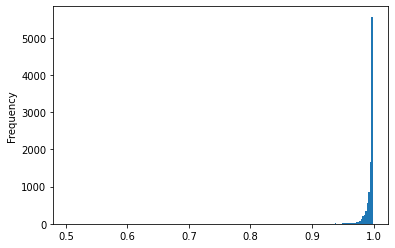

In [211]:
trade_news[trade_news['sentiment_common2'] == 'POSITIVE']['score2'].plot.hist(bins= 200) #0.98

In [19]:
trade_news.columns

Index(['published_at', 'title', 'description', 'content', 'url',
       'url_to_image', 'tags', 'id', 'original_path', 'publisher',
       'clean_content_prep_clean', 'clean_content_ner_prep_clean',
       'relevance_trade', 'clean_content_ner_prep_clean_511',
       'sentiment_common', 'prob_score', 'sentiment_common2', 'score2',
       'final_sentiment', 'loction_count', 'country_extraction',
       'product_word', 'product_word_map_product_group'],
      dtype='object')

In [ ]:
# try to tuning with  sentiment only 

In [44]:
def final(data) : 
    if data['sentiment_common'] == 'neutral' :
        if data['sentiment_common2'] == 'POSITIVE'  and data['score2'] >= 0.99625 :  #0.99
            return 'POS'
        elif data['sentiment_common2'] == 'POSITIVE'  and data['score2']< 0.99625 : 
            return 'NEU'
        
        elif data['sentiment_common2'] == 'NEGATIVE'  and data['score2'] > 0.987:
            return 'NEG'
        elif data['sentiment_common2'] == 'NEGATIVE'  and data['score2'] <=0.987:
            return 'NEU'
    else : 
            return  data['sentiment_common']
        

trade_news_test_trades['final_sentiment'] =  trade_news_test_trades.apply(lambda x : final(x) , axis = 1)
trade_news_test_trades['final_sentiment_score'] = trade_news_test_trades['final_sentiment']

trade_news_test_trades['final_sentiment_score'].replace('positive',1,inplace=True)
trade_news_test_trades['final_sentiment_score'].replace('POS',1,inplace=True)
trade_news_test_trades['final_sentiment_score'].replace('NEU',0,inplace=True)
trade_news_test_trades['final_sentiment_score'].replace('NEG',-1,inplace=True)
trade_news_test_trades['final_sentiment_score'].replace('negative',-1,inplace=True)

trade_news_test_trades['final_sentiment_score'].value_counts()
#print(trade_news_test_trades.columns)
y_expect_sentiment =trade_news_test_trades['Result (Sentiment)']
y_predict_sentiment = trade_news_test_trades['final_sentiment_score']

# evaluated with baseline performance 
cm = confusion_matrix(y_expect_sentiment, y_predict_sentiment)
accuracy = accuracy_score(y_expect_sentiment, y_predict_sentiment)
print('Accuracy Score :',accuracy)
cm_df = pd.DataFrame(cm,
                     index = ['Negative','Neutral','Positive'], 
                     columns = ['Negative','Neutral','Positive'])
cm_df        

import seaborn as sns
import matplotlib.pyplot as plt
#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True, cmap="YlGnBu")
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

KeyError: 'sentiment_common'

Accuracy Score : 0.3314917127071823


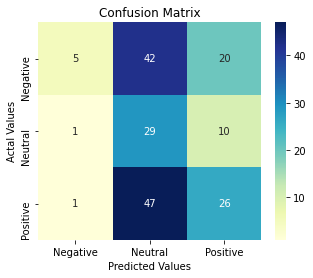

In [396]:
trade_news_test_trades['sentiment_common'].replace('positive',1, inplace=True) 
trade_news_test_trades['sentiment_common'].replace('neutral',0, inplace=True) 
trade_news_test_trades['sentiment_common'].replace('negative',-1, inplace=True) 


y_expect_sentiment_finance =trade_news_test_trades['Result (Sentiment)']
y_predict_sentiment_finance = trade_news_test_trades['sentiment_common']




# evaluated with baseline performance 
cm = confusion_matrix(y_expect_sentiment_finance, y_predict_sentiment_finance)
accuracy = accuracy_score(y_expect_sentiment_finance, y_predict_sentiment_finance)
print('Accuracy Score :',accuracy)
cm_df = pd.DataFrame(cm,
                     index = ['Negative','Neutral','Positive'], 
                     columns = ['Negative','Neutral','Positive'])
cm_df        

import seaborn as sns
import matplotlib.pyplot as plt
#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True, cmap="YlGnBu")
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()


In [388]:
print('Accuracy Score :',accuracy)

Accuracy Score : 0.4585635359116022


In [389]:
## Try to predict with  2 class positive and negative 
trade_news_test_trades['2_class_final'] = trade_news_test_trades['final_sentiment_score'].progress_apply(lambda x: \
                                                                                                        -1 if x== -1 else 1)
trade_news_test_trades['2_class_actual'] = trade_news_test_trades['Result (Sentiment)'].progress_apply(lambda x: \
                                                                                                        -1 if x== -1 else 1)

  0%|          | 0/181 [00:00<?, ?it/s]

  0%|          | 0/181 [00:00<?, ?it/s]

In [390]:
y_actual_2 = trade_news_test_trades['2_class_actual']
y_pred_2 = trade_news_test_trades['2_class_final']


In [391]:
tn, fp, fn, tp  = confusion_matrix(y_actual_2, y_pred_2).ravel()
accuracy = accuracy_score(y_actual_2, y_pred_2)
accuracy

0.6574585635359116

In [392]:
report_test = classification_report(y_pred_2, y_actual_2)
print('test set')
print(report_test) 

test set
              precision    recall  f1-score   support

          -1       0.36      0.56      0.44        43
           1       0.83      0.69      0.75       138

    accuracy                           0.66       181
   macro avg       0.60      0.62      0.60       181
weighted avg       0.72      0.66      0.68       181



True-negative: 24  False-positive: 43 
False-negative: 19  True-positive:  95


[Text(0, 0.5, 'Nagative'), Text(0, 1.5, 'Positive')]

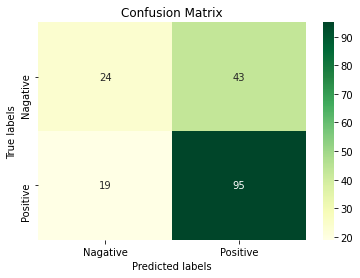

In [386]:
from sklearn.metrics import plot_confusion_matrix
tn, fp, fn, tp  = confusion_matrix(y_actual_2, y_pred_2).ravel()
print('True-negative:',tn , ' False-positive:',fp, '\nFalse-negative:',fn, ' True-positive: ',tp)  ##  fp predict  use to not -use 
cm = confusion_matrix(y_actual_2, y_pred_2)
cm
#plt.imshow(cm, cmap='binary')
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap = 'YlGn');  #YlGn
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Nagative', 'Positive'])
ax.yaxis.set_ticklabels(['Nagative', 'Positive'])

In [364]:
trade_news['final_sentiment'] =  trade_news.apply(lambda x : final(x) , axis = 1)

In [264]:
## test sentiemtn news  w


0      1
2      0
3     -1
4      1
5      1
      ..
290    0
292    0
293   -1
295   -1
296    1
Name: Result (Sentiment), Length: 181, dtype: int64

In [55]:

trade_news_test_trades['sentiment_common'], trade_news_test_trades['prob_score'] = zip(*trade_news_test_trades['clean_content_ner_prep_clean'].progress_apply(sentiment))


NameError: name 'sentiment' is not defined

In [110]:
trade_news_test_trades['sentiment_common2'], trade_news_test_trades['score2'] = zip(*trade_news_test_trades.progress_apply(

                                                            lambda x  :  sentiment_2class(x['clean_content_ner_prep_clean']) if x['sentiment_common'] == 'neutral' 

                                                                         else ('-',-1) , axis = 1) )

  0%|          | 0/181 [00:00<?, ?it/s]

/tmp/ipykernel_820702/3492348881.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trade_news_test_trades['sentiment_common2'], trade_news_test_trades['score2'] = zip(*trade_news_test_trades.progress_apply(


/tmp/ipykernel_820702/2152362813.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trade_news_test_trades['final_sentiment'] =  trade_news_test_trades.apply(lambda x : final(x) , axis = 1)
/tmp/ipykernel_820702/2152362813.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trade_news_test_trades['final_sentiment_score'] = trade_news_test_trades['final_sentiment']


In [1]:

trade_news_test_trades['final_sentiment'] =  trade_news_test_trades.apply(lambda x : final(x) , axis = 1)
trade_news_test_trades['final_sentiment_score'] = trade_news_test_trades['final_sentiment']

trade_news_test_trades['final_sentiment_score'].replace('positive',1,inplace=True)
trade_news_test_trades['final_sentiment_score'].replace('POS',1,inplace=True)
trade_news_test_trades['final_sentiment_score'].replace('NEU',0,inplace=True)
trade_news_test_trades['final_sentiment_score'].replace('NEG',-1,inplace=True)
trade_news_test_trades['final_sentiment_score'].replace('negative',-1,inplace=True)

trade_news_test_trades['final_sentiment_score'].value_counts()
#print(trade_news_test_trades.columns)
y_expect_sentiment =trade_news_test_trades['Result (Sentiment)']
y_predict_sentiment = trade_news_test_trades['final_sentiment_score']

# evaluated with baseline performance 
cm = confusion_matrix(y_expect_sentiment, y_predict_sentiment)
accuracy = accuracy_score(y_expect_sentiment, y_predict_sentiment)
print(accuracy)
cm_df = pd.DataFrame(cm,
                     index = ['Negative','Neutral','Positive'], 
                     columns = ['Negative','Neutral','Positive'])
cm_df

NameError: name 'trade_news_test_trades' is not defined

In [188]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from keras.models import Sequential
from keras.layers import Dense 
from keras.layers import Dense
from keras.layers import Dropout
from tensorflow.keras.optimizers import SGD,Adagrad
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.wrappers.scikit_learn import KerasRegressor
from keras.initializers import Constant

# Performance metrics
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, make_scorer, roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics.pairwise import cosine_similarity
# len(y_expect_sentiment)

array([11,  9, 54])

In [150]:
cm_df = pd.DataFrame(cm,
                     index = ['Negative','Neutral','Positive'], 
                     columns = ['Negative','Neutral','Positive'])
cm_df

,Negative,Neutral,Positive
Negative,20,7,40
Neutral,5,7,28
Positive,11,9,54


In [7]:
trade_news.groupby('final_sentiment').count()['score2'].reset_index()

,final_sentiment,score2
0,NEG,4622
1,NEU,2799
2,POS,8453
3,negative,320
4,positive,3183


<AxesSubplot:ylabel='Frequency'>

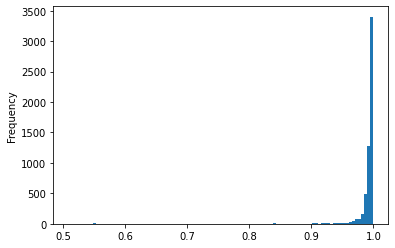

In [8]:
trade_news[trade_news['sentiment_common2'] == 'NEGATIVE']['score2'].plot.hist(bins=100) # 0.98

## Extract Location 


In [17]:
# drop dupplicated location 
country_all.drop_duplicates(subset=['keyword','country'],keep='first',  inplace=True)
country_all.dropna(subset=['country'], inplace=True)
country_all.drop(columns=['Unnamed: 0'], inplace=True, errors='ignore')

In [18]:
from spacy import displacy
from collections import Counter
try :
     nlp1
except:
     nlp1 = spacy.load('en_core_web_sm') #DATE , LANGUAGE  PERCENT , NORP ,CARDINAL,GPE,MONEY ,Non-GPE,LOC ,LANGUAGE 
exclude_ner = [ "GPE" ,"LOC"]

get_standard_name= dict(zip(country_all['keyword'], zip(country_all['country'],country_all['iso3']) ) )
##get_standard_name.get('UK')    #America

def ner_location(sentens_string) :
    doc1 = nlp1(sentens_string) 
    #print(nlp1(sentens_string))
    sentenss = []
    for sr in  doc1.ents :
        if sr.label_ in exclude_ner :
             sentenss.append((sr.text,sr.label_))
    sentenss_count = Counter(sentenss)  
    sentenss_count = dict(sentenss_count)
    
    map_country = [ get_standard_name.get(key[0]) for key,value in  sentenss_count.items()  if get_standard_name.get(key[0]) != None] 
    
    return sentenss_count ,map_country         
 
#x =  ner_process(df_th.loc[1,'job_description'])

In [19]:
trade_news.columns

Index(['published_at', 'title', 'description', 'content', 'url',
       'url_to_image', 'tags', 'id', 'original_path', 'publisher',
       'clean_content_prep_clean', 'clean_content_ner_prep_clean',
       'relevance_trade', 'clean_content_ner_prep_clean_511',
       'sentiment_common', 'prob_score', 'sentiment_common2', 'score2',
       'final_sentiment'],
      dtype='object')

In [20]:
trade_news['loction_count'],trade_news['country_extraction']  = zip(*trade_news['content'].progress_apply(ner_process))

  0%|          | 0/19377 [00:00<?, ?it/s]

/home/nick/envDITP/lib/python3.8/site-packages/pandas/core/common.py:228: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


In [63]:
trade_news

,published_at,title,description,content,url,url_to_image,tags,id,original_path,publisher,...,clean_content_ner_prep_clean_511,sentiment_common,prob_score,sentiment_common2,score2,final_sentiment,loction_count,country_extraction,product_word,product_word_map_product_group
0,2021-03-07 00:00:00.000,Crude prices achieve budget-balancing levels f...,NaN,(Bloomberg) --Brent crude now trades above fis...,https://www.worldoil.com/news/2021/3/5/crude-p...,NaN,NaN,f437fb5f4170ab4e40c1c5ae029dfea8,wasbs://raw-data@stditp.blob.core.windows.net/...,World Oil,...,crude prices achieve budget balancing levels e...,positive,0.911365,-,-1.000000,positive,"{('the Middle East', 'LOC'): 1, ('Saudi Arabia...","[(Saudi Arabia, SAU)]","[gold, oil, rice, rices]","[(gold, gemstone and jewelry), (oil, น้ำมันปาล..."
1,2021-03-07 00:00:00.000,‘It was an incredibly difficult book to write’...,"Everything that I was feeling – the pain, the ...",Imbolo Mbue has been working on her latest nov...,https://www.independent.co.uk/arts-entertainme...,https://static.independent.co.uk/2021/03/02/15...,NaN,4bf5df3f0e6871ea494282c2a0281dd3,wasbs://raw-data@stditp.blob.core.windows.net/...,Independent,...,‘ it incredibly difficult book write working l...,neutral,0.980492,POSITIVE,0.998525,POS,"{('US', 'GPE'): 3, ('Flint', 'GPE'): 1, ('Mich...","[(United States, USA), (United States, USA), (...","[oil, rice]","[(oil, น้ำมันปาล์ม), (rice, rice)]"
2,2021-03-07 00:00:00.000,Oil prices vault towards $70 as the OPEC-fuele...,NaN,(Bloomberg) - Oil rallied toward $70 a barrel ...,https://www.worldoil.com/news/2021/3/5/oil-pri...,NaN,NaN,d5e7973039982ced652fbb015fbc99a9,wasbs://raw-data@stditp.blob.core.windows.net/...,World Oil,...,oil prices vault towards fueled crude rally co...,positive,0.933114,-,-1.000000,positive,"{('Asia', 'LOC'): 2, ('Saudi Arabia', 'GPE'): ...","[(Saudi Arabia, SAU), (Saudi Arabia, SAU), (Un...","[diesel, gold, oil, rice, rices, ring]","[(diesel, สินค้าชิ้นส่วนยานยนต์และอุปกรณ์), (g..."
3,2021-03-07 00:00:00.000,Saudi Arabia takes steps to lead the $700B glo...,NaN,DUBAI (Bloomberg) --Sun-scorched expanses and ...,https://www.worldoil.com/news/2021/3/5/saudi-a...,NaN,NaN,fdccbea4afa9477e908181c67b3a7735,wasbs://raw-data@stditp.blob.core.windows.net/...,World Oil,...,takes steps lead b global hydrogen market scor...,neutral,0.920979,POSITIVE,0.998136,POS,"{('DUBAI', 'GPE'): 1, ('Red Sea', 'LOC'): 1, (...","[(Saudi Arabia, SAU), (Taiwan, TWN), (Australi...","[base, brace, capacity, corn, dust, food, form...","[(base, gemstone and jewelry), (brace, textile..."
4,2021-03-07 00:00:01.000,21 Dangerous TikTok Trends Every Parent Should...,Overdosing on allergy medication and starting ...,"Some people will do anything to go viral, from...",https://www.newsweek.com/21-dangerous-tiktok-t...,https://d.newsweek.com/en/full/1750177/tiktok-...,NaN,0322039bb366b9941476888ac15a1ef9,wasbs://raw-data@stditp.blob.core.windows.net/...,Newsweek,...,dangerous tiktok trends every parent should be...,neutral,0.980523,NEGATIVE,0.996056,NEG,"{('Italy', 'GPE'): 1}","[(Italy, ITA)]","[acid, bodies, care, cars, corn, food, form, h...","[(acid, ผลไม้กระป๋องและแปรรูป), (bodies, สินค้..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19372,2022-03-04 13:00:00.000,Europe Returns to South Africa for Coal After ...,Europe Returns to South Africa for Coal After ...,"Paul Burkhardt and Julian Lee\nFri, March 4, 2...",https://finance.yahoo.com/news/europe-returns-...,NaN,NaN,77ed7cd644f8aa08f8b2d444f22b1079,wasbs://raw-data@tradeprodstditp.blob.core.win...,Yahoo Finance,...,after sanctions julian leenfri · min readnn su...,neutral,0.887254,POSITIVE,0.994893,POS,"{('Europe', 'LOC'): 3, ('Asia.\n\nThere', 'GPE...","[(Russia, RUS), (United States, USA), (Colombi...","[food, rice, rices, ring, shell, tons]","[(food, food preparations ), (rice, rice), (ri..."
19373,2022-03-04 19:50:00.000,Global Food Prices Reach All-Time High in Febr...,Global Food Pr

In [229]:
trade_news.to_csv('trad_news_extraction_country.csv', index=False)

## Product Extraction 

In [21]:
# drop duplicated value 

relate_product.drop_duplicates(subset=['keyword','product'], inplace=True)

In [22]:
relate_product.dropna(inplace=True)

In [23]:
# drop common word keys 
common_list = ['articles','goods','kind','use','parts','goods','pipes','preparations','purpose','shapes','use','cuts','cc','mm','shock','bs']
relate_product = relate_product[~relate_product['keyword'].isin(common_list)]

In [24]:
# check len string 
relate_product['keyword_len_string'] =relate_product['keyword'].str.len()
relate_product = relate_product[(relate_product['keyword_len_string'] >3) | (relate_product['keyword']=='oil')]

In [25]:
product_mapping.get('GABA rice')

NameError: name 'product_mapping' is not defined

In [26]:
relate_product_group =relate_product.groupby('keyword')['product'].apply(lambda x: '|'.join(x)).reset_index()

In [27]:
relate_product_group['len_product'] = relate_product_group['product'].apply(lambda x : len(x.split('|')))

In [28]:
relate_product_group[relate_product_group['len_product'] > 1]

,keyword,product,len_product
286,flour,สิ่งปรุงรสอาหาร|ไม้และผลิตภัณฑ์ไม้,2
297,fruits,fruits|ผลไม้กระป๋องและแปรรูป,2
389,kitchenware,ไม้และผลิตภัณฑ์ไม้|ผลิตภัณฑ์พลาสติก,2
441,mitts,rubber products|เครื่องนุ่งห่ม,2
512,plastics,รองเท้าและชิ้นส่วน|ผลิตภัณฑ์พลาสติก,2
581,rubber,rubber products|รองเท้าและชิ้นส่วน|natural rubber,3
680,swimwear,textile & garments|เครื่องนุ่งห่ม,2
682,tableware,ไม้และผลิตภัณฑ์ไม้|ผลิตภัณฑ์พลาสติก,2


In [29]:
relate_product_group[relate_product_group['keyword'] == 'nes']

,keyword,product,len_product


In [30]:
relate_product_group

,keyword,product,len_product
0,A1 Extra Super,rice,1
1,A1 super,rice,1
2,Basmati,rice,1
3,Chinese lacquer,herb,1
4,GABA rice,rice,1
...,...,...,...
745,yarrow oil,cosmetic perfumery and soaps,1
746,yarrow oils,cosmetic perfumery and soaps,1
747,yuca,cassava,1
748,yucas,cassava,1


In [31]:
def map_product(contence, df_map =relate_product_group ) :
    wpt = nltk.WordPunctTokenizer()
    token =  wpt.tokenize(contence.lower())
    lower_contence = contence.lower()
    key_product =  relate_product_group['keyword'].to_list()
    list_product = []
    for key in key_product : 
        if len(key.split(' ')) > 1 and (key in lower_contence) : 
                list_product.append(key)
            
        elif  len(key.split(' ')) == 1   :
            if key in lower_contence :
                list_product.append(key) 
                
    # created dict  mapping  

    product_mapping =  dict(zip(relate_product_group['keyword'],relate_product_group['product']))            
    
    map_product_group = [ (i,product_mapping.get(i)) for i in list_product]
    
    
#             product_token = list(filter( lambda r :  r in  key_product , token))
#             print()
#             list_product.extend(product_token)
    return   list_product    , map_product_group 

In [32]:
map_product(trade_news['clean_content_prep_clean'][30])

(['load', 'oil', 'ring'],
 [('load', 'ไม้และผลิตภัณฑ์ไม้'),
  ('oil', 'น้ำมันปาล์ม'),
  ('ring', 'gemstone and jewelry')])

In [35]:
trade_news['product_word'],trade_news['product_word_map_product_group'] = zip(*trade_news['clean_content_prep_clean'].progress_apply(map_product))

  0%|          | 0/19377 [00:00<?, ?it/s]

/home/nick/envDITP/lib/python3.8/site-packages/pandas/core/common.py:228: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


In [36]:
trade_news

,published_at,title,description,content,url,url_to_image,tags,id,original_path,publisher,...,clean_content_ner_prep_clean_511,sentiment_common,prob_score,sentiment_common2,score2,final_sentiment,loction_count,country_extraction,product_word,product_word_map_product_group
0,2021-03-07 00:00:00.000,Crude prices achieve budget-balancing levels f...,NaN,(Bloomberg) --Brent crude now trades above fis...,https://www.worldoil.com/news/2021/3/5/crude-p...,NaN,NaN,f437fb5f4170ab4e40c1c5ae029dfea8,wasbs://raw-data@stditp.blob.core.windows.net/...,World Oil,...,crude prices achieve budget balancing levels e...,positive,0.911365,-,-1.000000,positive,"{('the Middle East', 'LOC'): 1, ('Saudi Arabia...","[(Saudi Arabia, SAU)]","[gold, oil, rice, rices]","[(gold, gemstone and jewelry), (oil, น้ำมันปาล..."
1,2021-03-07 00:00:00.000,‘It was an incredibly difficult book to write’...,"Everything that I was feeling – the pain, the ...",Imbolo Mbue has been working on her latest nov...,https://www.independent.co.uk/arts-entertainme...,https://static.independent.co.uk/2021/03/02/15...,NaN,4bf5df3f0e6871ea494282c2a0281dd3,wasbs://raw-data@stditp.blob.core.windows.net/...,Independent,...,‘ it incredibly difficult book write working l...,neutral,0.980492,POSITIVE,0.998525,POS,"{('US', 'GPE'): 3, ('Flint', 'GPE'): 1, ('Mich...","[(United States, USA), (United States, USA), (...","[oil, rice]","[(oil, น้ำมันปาล์ม), (rice, rice)]"
2,2021-03-07 00:00:00.000,Oil prices vault towards $70 as the OPEC-fuele...,NaN,(Bloomberg) - Oil rallied toward $70 a barrel ...,https://www.worldoil.com/news/2021/3/5/oil-pri...,NaN,NaN,d5e7973039982ced652fbb015fbc99a9,wasbs://raw-data@stditp.blob.core.windows.net/...,World Oil,...,oil prices vault towards fueled crude rally co...,positive,0.933114,-,-1.000000,positive,"{('Asia', 'LOC'): 2, ('Saudi Arabia', 'GPE'): ...","[(Saudi Arabia, SAU), (Saudi Arabia, SAU), (Un...","[diesel, gold, oil, rice, rices, ring]","[(diesel, สินค้าชิ้นส่วนยานยนต์และอุปกรณ์), (g..."
3,2021-03-07 00:00:00.000,Saudi Arabia takes steps to lead the $700B glo...,NaN,DUBAI (Bloomberg) --Sun-scorched expanses and ...,https://www.worldoil.com/news/2021/3/5/saudi-a...,NaN,NaN,fdccbea4afa9477e908181c67b3a7735,wasbs://raw-data@stditp.blob.core.windows.net/...,World Oil,...,takes steps lead b global hydrogen market scor...,neutral,0.920979,POSITIVE,0.998136,POS,"{('DUBAI', 'GPE'): 1, ('Red Sea', 'LOC'): 1, (...","[(Saudi Arabia, SAU), (Taiwan, TWN), (Australi...","[base, brace, capacity, corn, dust, food, form...","[(base, gemstone and jewelry), (brace, textile..."
4,2021-03-07 00:00:01.000,21 Dangerous TikTok Trends Every Parent Should...,Overdosing on allergy medication and starting ...,"Some people will do anything to go viral, from...",https://www.newsweek.com/21-dangerous-tiktok-t...,https://d.newsweek.com/en/full/1750177/tiktok-...,NaN,0322039bb366b9941476888ac15a1ef9,wasbs://raw-data@stditp.blob.core.windows.net/...,Newsweek,...,dangerous tiktok trends every parent should be...,neutral,0.980523,NEGATIVE,0.996056,NEG,"{('Italy', 'GPE'): 1}","[(Italy, ITA)]","[acid, bodies, care, cars, corn, food, form, h...","[(acid, ผลไม้กระป๋องและแปรรูป), (bodies, สินค้..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19372,2022-03-04 13:00:00.000,Europe Returns to South Africa for Coal After ...,Europe Returns to South Africa for Coal After ...,"Paul Burkhardt and Julian Lee\nFri, March 4, 2...",https://finance.yahoo.com/news/europe-returns-...,NaN,NaN,77ed7cd644f8aa08f8b2d444f22b1079,wasbs://raw-data@tradeprodstditp.blob.core.win...,Yahoo Finance,...,after sanctions julian leenfri · min readnn su...,neutral,0.887254,POSITIVE,0.994893,POS,"{('Europe', 'LOC'): 3, ('Asia.\n\nThere', 'GPE...","[(Russia, RUS), (United States, USA), (Colombi...","[food, rice, rices, ring, shell, tons]","[(food, food preparations ), (rice, rice), (ri..."
19373,2022-03-04 19:50:00.000,Global Food Prices Reach All-Time High in Febr...,Global Food Pr

In [37]:
partner.head()

,product,exporter,importer,value,%TH_Export,%cummul,rank,partner_name
0,Corn,THA,PHL,1.929841e+07,0.298433,0.298433,1.0,Philippines
1,Corn,THA,MMR,1.664991e+07,0.257477,0.555910,2.0,Myanmar
2,Corn,THA,VNM,1.050087e+07,0.162387,0.718297,3.0,Viet Nam
3,Cosmetic Perfumery and Soaps,THA,JPN,4.355512e+08,0.142652,0.142652,1.0,Japan
4,Cosmetic Perfumery and Soaps,THA,PHL,2.807177e+08,0.091941,0.234593,2.0,Philippines


# partner and compatitor

In [38]:
#compatetior
partner_group =  partner.groupby(by=['product','exporter'])['importer'].apply( lambda x : '|'.join(x)).reset_index()
# 


competiors_group = competiors[competiors['competitor_flag'] !='THA' ] \
.groupby(by=['product'])['exporter'] \
.apply( lambda x : '|'.join(x)).reset_index()

In [39]:
trade_news.columns

Index(['published_at', 'title', 'description', 'content', 'url',
       'url_to_image', 'tags', 'id', 'original_path', 'publisher',
       'clean_content_prep_clean', 'clean_content_ner_prep_clean',
       'relevance_trade', 'clean_content_ner_prep_clean_511',
       'sentiment_common', 'prob_score', 'sentiment_common2', 'score2',
       'final_sentiment', 'loction_count', 'country_extraction',
       'product_word', 'product_word_map_product_group'],
      dtype='object')

In [40]:
# created cross join value 

# country datafrane  
list_country = []
for index,i in trade_news.iterrows() :
     for c in i['country_extraction']  :
        list_country.append((index,c[1],c[0]))
## product group  
list_product_group  = []
for index,i in trade_news.iterrows() :
    for p in i['product_word_map_product_group'] :
        list_product_group.append((index,p[1],p[0]))
country_df =  pd.DataFrame(list_country,columns=['news_index','country_iso3','full_name'])
country_df.drop_duplicates(inplace=True)
product_group_df = pd.DataFrame(list_product_group, columns = ['news_index','product_group','product'])
product_group_df.drop_duplicates(subset=['news_index','product_group'],inplace=True,keep = 'first')
df_all = country_df.merge(product_group_df,  left_on='news_index',right_on='news_index')

In [67]:
df_all

,news_index,country_iso3,full_name,product_group,product
0,0,SAU,Saudi Arabia,gemstone and jewelry,gold
1,0,SAU,Saudi Arabia,น้ำมันปาล์ม,oil
2,0,SAU,Saudi Arabia,rice,rice
3,1,USA,United States,น้ำมันปาล์ม,oil
4,1,USA,United States,rice,rice
...,...,...,...,...,...
253989,19376,COL,Colombia,food preparations,food
253990,19376,COL,Colombia,rice,rice
253991,19376,COL,Colombia,gemstone and jewelry,ring
253992,19376,COL,Colombia,eggs,shell


In [42]:
partner

,product,exporter,importer,value,%TH_Export,%cummul,rank,partner_name
0,Corn,THA,PHL,1.929841e+07,0.298433,0.298433,1.0,Philippines
1,Corn,THA,MMR,1.664991e+07,0.257477,0.555910,2.0,Myanmar
2,Corn,THA,VNM,1.050087e+07,0.162387,0.718297,3.0,Viet Nam
3,Cosmetic Perfumery and Soaps,THA,JPN,4.355512e+08,0.142652,0.142652,1.0,Japan
4,Cosmetic Perfumery and Soaps,THA,PHL,2.807177e+08,0.091941,0.234593,2.0,Philippines
...,...,...,...,...,...,...,...,...
174,ไม้และผลิตภัณฑ์ไม้,THA,CHN,1.289919e+09,0.470814,0.470814,1.0,China
175,ไม้และผลิตภัณฑ์ไม้,THA,KOR,2.337952e+08,0.085334,0.556148,2.0,"Korea, Republic of"
176,ไม้และผลิตภัณฑ์ไม้,THA,ARE,2.090273e+08,0.076294,0.632442,3.0,United Arab Emirates
177,ไม้และผลิตภัณฑ์ไม้,THA,SAU,1.730220e+08,0.063152,0.695594,4.0,Saudi Arabia


In [43]:
df_all.shape

(253994, 5)

In [44]:
pd.unique(partner['product'])

array(['Corn', 'Cosmetic Perfumery and Soaps', 'Food Preparations ',
       'Gemstone and Jewelry', 'Herb', 'Medicaments', 'Natural Rubber',
       'Poultry', 'Rice', 'Rubber Products', 'Textile & Garments', 'กุ้ง',
       'น้ำมันปาล์ม', 'ผลิตภัณฑ์พลาสติก', 'ผลไม้กระป๋องและแปรรูป',
       'รองเท้าและชิ้นส่วน', 'สินค้าชิ้นส่วนยานยนต์และอุปกรณ์',
       'สิ่งปรุงรสอาหาร', 'อาหารทะเลกระป๋องและแปรรูป', 'อาหารสัตว์เลี้ยง',
       'เครื่องนุ่งห่ม', 'เฟอร์นิเจอร์และชิ้นส่วน', 'ไก่แปรรูป',
       'ไม้และผลิตภัณฑ์ไม้'], dtype=object)

In [45]:
partner['product_clean'] = partner['product'].str.lower().str.rstrip()
competiors['product_clean'] = competiors['product'].str.lower().str.rstrip()

In [46]:
partner.drop_duplicates(subset=['product_clean','importer'], inplace=True)

In [47]:
competiors.drop_duplicates(subset=['product_clean','exporter'],inplace=True, keep= 'first')

In [48]:
df_all_partner = df_all.merge(partner,  left_on=['country_iso3','product_group'], right_on=['importer','product_clean'], how = 'left')

In [49]:
competiors

,product,exporter,importer,value,mkt,%Share_to_MKT,%cummul,rank,competitor_flag,competitor_name,product_clean
0,Cosmetic Perfumery and Soaps,CHN,AUS,3.575252e+08,"Cosmetic Perfumery and Soaps,AUS",0.364560,0.364560,1.0,Competitor,China,cosmetic perfumery and soaps
1,Cosmetic Perfumery and Soaps,THA,AUS,2.122244e+08,"Cosmetic Perfumery and Soaps,AUS",0.216400,0.580960,2.0,THA,Thailand,cosmetic perfumery and soaps
2,Cosmetic Perfumery and Soaps,SGP,AUS,1.948657e+08,"Cosmetic Perfumery and Soaps,AUS",0.198700,0.779660,3.0,Competitor,Singapore,cosmetic perfumery and soaps
3,Cosmetic Perfumery and Soaps,JPN,CHN,5.803161e+09,"Cosmetic Perfumery and Soaps,CHN",0.288687,0.288687,1.0,Competitor,Japan,cosmetic perfumery and soaps
4,Cosmetic Perfumery and Soaps,KOR,CHN,5.735758e+09,"Cosmetic Perfumery and Soaps,CHN",0.285334,0.574021,2.0,Competitor,"Korea, Republic of",cosmetic perfumery and soaps
...,...,...,...,...,...,...,...,...,...,...,...
265,ไม้และผลิตภัณฑ์ไม้,PNG,CHN,6.068876e+08,"ไม้และผลิตภัณฑ์ไม้,CHN",0.066107,0.687252,4.0,Competitor,Papua New Guinea,ไม้และผลิตภัณฑ์ไม้
266,ไม้และผลิตภัณฑ์ไม้,SLB,CHN,3.351052e+08,"ไม้และผลิตภัณฑ์ไม้,CHN",0.036502,0.723754,5.0,Competitor,Solomon Islands,ไม้และผลิตภัณฑ์ไม้
267,ไม้และผลิตภัณฑ์ไม้,COD,CHN,3.283060e+08,"ไม้และผลิตภัณฑ์ไม้,CHN",0.035761,0.759516,6.0,Competitor,"Congo, The Democratic Republic of the",ไม้และผลิตภัณฑ์ไม้
268,ไม้และผลิตภัณฑ์ไม้,CHL,CHN,2.829951e+08,"ไม้และผลิตภัณฑ์ไม้,CHN",0.030826,0.790342,7.0,Competitor,Chile,ไม้และผลิตภัณฑ์ไม้


In [50]:
df_all_competitor = df_all.merge(competiors[competiors['competitor_flag'] !='THA' ]  \
                                 , right_on= ['exporter','product_clean'] , left_on= ['country_iso3','product_group'] \
                                 , how = 'left')

In [51]:
df_all_competitor.columns

Index(['news_index', 'country_iso3', 'full_name', 'product_group', 'product_x',
       'product_y', 'exporter', 'importer', 'value', 'mkt', '%Share_to_MKT',
       '%cummul', 'rank', 'competitor_flag', 'competitor_name',
       'product_clean'],
      dtype='object')

In [52]:
df_all_competitor = df_all_competitor[['news_index', 'country_iso3','competitor_flag', 'exporter',
       'product_clean']].rename(columns  = {'exporter':'comp_name','product_clean':'product_clean_competitor'})


In [53]:
df_all_competitor

,news_index,country_iso3,competitor_flag,comp_name,product_clean_competitor
0,0,SAU,NaN,NaN,NaN
1,0,SAU,NaN,NaN,NaN
2,0,SAU,NaN,NaN,NaN
3,1,USA,NaN,NaN,NaN
4,1,USA,NaN,NaN,NaN
...,...,...,...,...,...
253989,19376,COL,NaN,NaN,NaN
253990,19376,COL,NaN,NaN,NaN
253991,19376,COL,NaN,NaN,NaN
253992,19376,COL,NaN,NaN,NaN


In [54]:
merge_partner_com =  pd.concat( [df_all_partner, df_all_competitor[['product_clean_competitor','comp_name' ]]],axis=1) 

In [55]:
merge_partner_com

,news_index,country_iso3,full_name,product_group,product_x,product_y,exporter,importer,value,%TH_Export,%cummul,rank,partner_name,product_clean,product_clean_competitor,comp_name
0,0,SAU,Saudi Arabia,gemstone and jewelry,gold,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,SAU,Saudi Arabia,น้ำมันปาล์ม,oil,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,SAU,Saudi Arabia,rice,rice,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,USA,United States,น้ำมันปาล์ม,oil,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,USA,United States,rice,rice,Rice,THA,USA,1.092100e+09,0.180131,0.180131,1.0,United States,rice,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253989,19376,COL,Colombia,food preparations,food,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
253990,19376,COL,Colombia,rice,rice,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
253991,19376,COL,Colombia,gemstone and jewelry,ring,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
253992,19376,COL,Colombia,eggs,shell,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [61]:
filter_com_partner =  merge_partner_com[ ( ~merge_partner_com['exporter'].isnull()) | ( ~merge_partner_com['comp_name'].isnull())]

In [56]:
filter_com_partner

NameError: name 'filter_com_partner' is not defined

In [21]:
trade_news[ trade_news['final_sentiment']== 'NEU']

,published_at,title,description,content,url,url_to_image,tags,id,original_path,publisher,...,clean_content_ner_prep_clean_511,sentiment_common,prob_score,sentiment_common2,score2,final_sentiment,loction_count,country_extraction,product_word,product_word_map_product_group
4,2021-03-07 00:00:01.000,21 Dangerous TikTok Trends Every Parent Should...,Overdosing on allergy medication and starting ...,"Some people will do anything to go viral, from...",https://www.newsweek.com/21-dangerous-tiktok-t...,https://d.newsweek.com/en/full/1750177/tiktok-...,NaN,0322039bb366b9941476888ac15a1ef9,wasbs://raw-data@stditp.blob.core.windows.net/...,Newsweek,...,dangerous tiktok trends every parent should be...,neutral,0.980523,NEGATIVE,0.996056,NEU,"{('Italy', 'GPE'): 1}","[('Italy', 'ITA')]","['acid', 'bodies', 'care', 'cars', 'corn', 'fo...","[('acid', 'ผลไม้กระป๋องและแปรรูป'), ('bodies',..."
7,2021-03-07 00:05:27.000,Ikea boss warns tariffs will lead to higher pr...,"Jesper Brodin, who heads the firm, says he fea...","By Jonathan JosephsBusiness reporter, BBC News...",https://www.bbc.co.uk/news/business-56296028,https://ichef.bbci.co.uk/news/1024/branded_new...,NaN,e28318d1eba7cc0d6f392b96a351a630,wasbs://raw-data@stditp.blob.core.windows.net/...,BBC News,...,ikea boss warns tariffs lead higher prices by ...,neutral,0.838621,POSITIVE,0.992863,NEU,"{('US', 'GPE'): 2, ('India', 'GPE'): 3, ('Mumb...","[('United States', 'USA'), ('India', 'IND'), (...","['base', 'dresses', 'form', 'furniture', 'hops...","[('base', 'gemstone and jewelry'), ('dresses',..."
10,2021-03-07 00:15:34.000,What's your pension invested in?,"While pension pots are going green, how easy i...",By Howard MustoeBusiness reporter\nimage copyr...,https://www.bbc.co.uk/news/business-56170726,https://ichef.bbci.co.uk/news/1024/branded_new...,NaN,f09a96ee281a60cd6bcf45d0286df525,wasbs://raw-data@stditp.blob.core.windows.net/...,BBC News,...,what pension invested by reporterimage copyrig...,neutral,0.996238,NEGATIVE,0.991387,NEU,"{('London', 'GPE'): 1, ('US', 'GPE'): 1, ('Arc...","[('South Africa', 'ZAF'), ('United States', 'U...","['base', 'cannabis', 'dust', 'form', 'forms', ...","[('base', 'gemstone and jewelry'), ('cannabis'..."
14,2021-03-07 00:22:54.000,Ethiopia's Tigray crisis: 'We're the governmen...,The BBC's Girmay Gebru recounts his experience...,image captionGirmay Gebru has been working for...,https://www.bbc.co.uk/news/world-africa-56284991,https://ichef.bbci.co.uk/news/1024/branded_new...,NaN,d2f3224c18fd557f7af7e251655488ec,wasbs://raw-data@stditp.blob.core.windows.net/...,BBC News,...,tigray crisis we government know image caption...,neutral,0.979130,POSITIVE,0.993017,NEU,"{('Mekelle', 'GPE'): 2, ('Ethiopia', 'GPE'): 3...","[('Ethiopia', 'ETH'), ('Sudan', 'SDN')]","['base', 'beds', 'food', 'form', 'oil', 'room'...","[('base', 'gemstone and jewelry'), ('beds', 'เ..."
15,2021-03-07 00:27:00.000,"US Scientists Question Single Dose for Pfizer,...",<ol><li>US Scientists Question Single Dose for...,© Alex McIntyre/The Greeley Tribune/ReutersWAS...,https://www.wsj.com/articles/u-s-scientists-sk...,https://img-s-msn-com.akamaized.net/tenant/amp...,NaN,81a3b47293e4b671da41a952740b0128,wasbs://raw-data@stditp.blob.core.windows.net/...,The Wall Street Journal,...,scientists question single dose pfizer msnnow ...,neutral,0.990406,POSITIVE,0.990562,NEU,"{('U.S.', 'GPE'): 8, ('Md.', 'GPE'): 1, ('N.C....","[('United States', 'USA'), ('United Kingdom', ...","['base', 'bodies', 'food', 'form', 'hair', 'me...","[('base', 'gemstone and jewelry'), ('bodies', ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19363,2022-02-25 08:43:00.000,Commodity Prices Inflated by 40% by Risk Premi...,Commodity Prices Inflated by 40% by Risk Premi...,"Gerson Freitas Jr.\nFri, February 25, 2022, 10...",https://finance.yahoo.com/news/commodity-price...,NaN,NaN,6acc3474dcd8d2cb7b4c27ed3905bfac,wasbs://raw-data@tradeprodstditp.blob.core.win...,Yahoo Finance,...,say

In [31]:
trade_news.tail(20)

,published_at,title,description,content,url,url_to_image,tags,id,original_path,publisher,...,clean_content_ner_prep_clean_511,sentiment_common,prob_score,sentiment_common2,score2,final_sentiment,loction_count,country_extraction,product_word,product_word_map_product_group
19357,2022-02-25 14:31:00.000,Russia-Ukraine Crisis Spark Rally in Commodity...,Russia-Ukraine Crisis Spark Rally in Commodity...,Sweta Killa\n23 February 2022·4-min read\nIn t...,https://sg.finance.yahoo.com/news/russia-ukrai...,NaN,NaN,c09069763b9a494effcf62d52d3af346,wasbs://raw-data@tradeprodstditp.blob.core.win...,Yahoo Finance,...,crisis spark rally commodity etfs sweta killan...,neutral,0.930337,POSITIVE,0.997714,POS,"{('Sweta', 'GPE'): 1, ('Moscow', 'GPE'): 1, ('...","[('United States', 'USA'), ('Ukraine', 'UKR'),...","['base', 'corn', 'dust', 'form', 'gold', 'load...","[('base', 'gemstone and jewelry'), ('corn', 'c..."
19358,2022-02-21 00:15:00.000,Sylvania Platinum Trims FY 2022 Production Gui...,Sylvania Platinum Trims FY 2022 Production Gui...,By Jaime Llinares Taboada\n\nSylvania Platinum...,https://www.marketwatch.com/story/sylvania-pla...,NaN,NaN,abe830567d1b0514f56ebd94fd3f8dcc,wasbs://raw-data@tradeprodstditp.blob.core.win...,MarketWatch,...,by jaime llinares taboadannsylvania platinum l...,negative,0.988351,-,-1.000000,negative,"{('London', 'GPE'): 1, ('Lesedi', 'GPE'): 3, (...","[('South Africa', 'ZAF')]","['base', 'form', 'metal', 'platinum', 'rice', ...","[('base', 'gemstone and jewelry'), ('form', 'ผ..."
19359,2022-02-02 15:27:00.000,CANADA-CRUDE-Heavy crude discount continues to...,CANADA-CRUDE-Heavy crude discount continues to...,Sponsored LinksSponsored Links\nPromoted Links...,https://www.nasdaq.com/articles/canada-crude-h...,NaN,NaN,ec3b7d13e93c6f1ee94bae050b7c4e8f,wasbs://raw-data@tradeprodstditp.blob.core.win...,Nasdaq,...,crude discount continues widen sponsored links...,neutral,0.815288,POSITIVE,0.985131,NEU,"{('Hardisty', 'GPE'): 1, ('Alberta', 'GPE'): 1...","[('Canada', 'CAN'), ('United States', 'USA')]","['oil', 'rice', 'rices']","[('oil', 'น้ำมันปาล์ม'), ('rice', 'rice'), ('r..."
19360,2022-03-02 13:47:00.000,U.S. Gold Corp. Sees Gold Prices Rallying -- C...,U.S. Gold Corp. Sees Gold Prices Rallying -- C...,By Chris Wack\n\nU.S. Gold Corp. said Wednesda...,https://www.marketwatch.com/story/u-s-gold-cor...,NaN,NaN,d582f646fcffda5de50eb0438e3ef801,wasbs://raw-data@tradeprodstditp.blob.core.win...,MarketWatch,...,by wacknnu s said track complete next phase en...,positive,0.999189,-,-1.000000,positive,"{('Wyoming', 'GPE'): 2, ('U.S.', 'GPE'): 1}","[('Jamaica', 'JAM'), ('United States', 'USA')]","['gold', 'rice', 'rices', 'ring']","[('gold', 'gemstone and jewelry'), ('rice', 'r..."
19361,2022-02-25 07:26:00.000,Argus launches Europe's first AdBlue price ref...,Argus launches Europe's first AdBlue price ref...,"Fri, February 25, 2022, 9:26 PM·3 min read\n\n...",https://finance.yahoo.com/news/argus-launches-...,https://s.yimg.com/ny/api/res/1.2/s_ge1NHaVqHR...,NaN,9629700c09889ece140c503a91061dd1,wasbs://raw-data@tradeprodstditp.blob.core.win...,Yahoo Finance,...,argus launches adblue price reference · min fe...,positive,0.955355,-,-1.000000,positive,"{('Germany', 'GPE'): 2, ('Europe', 'LOC'): 4, ...","[('Germany', 'DEU')]","['cars', 'diesel', 'dust', 'engines', 'exhaust...","[('cars', 'สินค้าชิ้นส่วนยานยนต์และอุปกรณ์'), ..."
19362,2022-02-25 02:32:00.000,Nitrogenous Fertilizer Market size to increase...,Nitrogenous Fertilizer Market size to increase...,"Fri, February 25, 2022, 4:00 PM·11 min read\n\...",https://finance.yahoo.com/news/nitrogenous-fer...,https://s.yimg.com/ny/api/res/1.2/GEiNzzszYuZd...,NaN,1e2df33632b2fc2a97936680cec33281,wasbs://raw-data@tradeprodstditp.blob.core.win...,Yahoo Finance,...,nitrogenous fertilizer market size increase k ...,positive,0.953068,-,-1.000000,positive,"{('YORK', 'GPE'): 1, ('North America', 'LOC'):...","[('Taiwan', 'TWN'), ('India', 'IND')]","['base', 'fruits', 'load', 'rice', 'ring', 'to...

In [22]:
u = 19363
trade_news['content'][u]
# trade_news[ trade_news['final_sentiment']== 'NEU']

'Gerson Freitas Jr.\\nFri, February 25, 2022, 10:43 PM·1 min read\\nIn this article:\\nHG=F\\n+1.85%\\n\\n(Bloomberg) -- Prices for some key raw materials are substantially inflated and could fall a “long way” if and when concerns ease about the Russian invasion of Ukraine, according to research firm Capital Economics Ltd.\\n\\nMost Read from Bloomberg\\n\\nRussia Vetoes UN Resolution as China Abstains: Ukraine Update\\n\\nTaiwan to Join in U.S.-Led Sanctions on Russia: Ukraine Update\\n\\nU.S. Sanctions Putin, Key Aides as Russian Forces Encircle Kyiv\\n\\nRussia Invasion of Ukraine Ignites European Security Crisis\\n\\nChina State Banks Restrict Financing for Russian Commodities\\n\\nThe prospect of supply disruptions stemming from international sanctions have added about 40% to prices for oil, aluminum and copper, Kieran Clancy, a Capital Economics analyst, wrote in a note to clients. Similar premiums probably are swelling agricultural commodities futures, he noted.\\n\\n“Although t